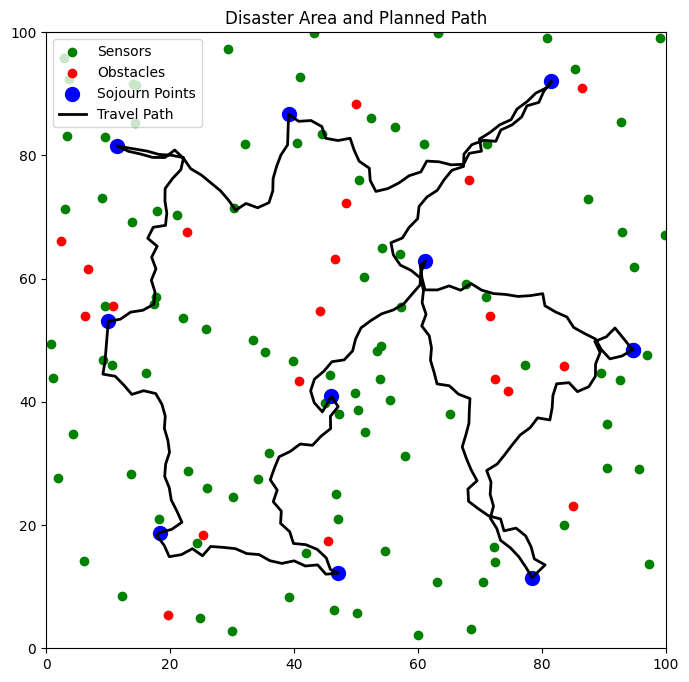

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Voronoi
from sklearn.cluster import KMeans
import random
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
# Environment parameters
AREA_SIZE = (100, 100)
NUM_SENSORS = 100
NUM_OBSTACLES = 20
NUM_SP = 10  # number of sojourn points
POP_SIZE = 20  # GA population size
PSO_PARTICLES = 20
MAX_ITERS = 50

# Initialize environment (sensors and obstacles)
sensors = np.random.rand(NUM_SENSORS, 2) * AREA_SIZE
obstacles = np.random.rand(NUM_OBSTACLES, 2) * AREA_SIZE

# Plot environment
def plot_environment(sensors, obstacles, path=None, SPs=None):
    plt.figure(figsize=(8,8))
    plt.scatter(sensors[:,0], sensors[:,1], c='green', label='Sensors')
    plt.scatter(obstacles[:,0], obstacles[:,1], c='red', label='Obstacles')
    if SPs is not None:
        plt.scatter(SPs[:,0], SPs[:,1], c='blue', label='Sojourn Points', s=100)
    if path is not None:
        path = np.array(path)
        plt.plot(path[:,0], path[:,1], 'k-', linewidth=2, label='Travel Path')
    plt.xlim(0, AREA_SIZE[0])
    plt.ylim(0, AREA_SIZE[1])
    plt.legend()
    plt.title('Disaster Area and Planned Path')
    plt.show()

# Step 1: Adaptive Environment Modeling (Voronoi-based)
def adaptive_environment_model(sensors):
    vor = Voronoi(sensors)
    return vor

# Step 2: GA + PSO Integration for SP Optimization
import numpy as np
import random
from sklearn.cluster import KMeans

# Hyperparameters
NUM_SP = 10  # Number of sensor placement spots
POP_SIZE = 30  # Genetic Algorithm population size
MAX_ITERS = 50  # Number of iterations for GA & PSO
PSO_PARTICLES = 20  # Number of PSO particles
COVERAGE_RADIUS = 20  # Sensor coverage radius

def fitness_func(SPs, sensors):
    """Compute fitness as coverage - overlapping penalty"""
    distances = np.linalg.norm(SPs[:, np.newaxis] - sensors, axis=2)
    covered = np.sum(np.any(distances <= COVERAGE_RADIUS, axis=0))

    # Compute overlap penalty efficiently
    SP_distances = np.linalg.norm(SPs[:, np.newaxis] - SPs, axis=2)
    overlap_penalty = -np.sum((SP_distances < COVERAGE_RADIUS) & (SP_distances > 0)) / len(SPs)

    return covered + overlap_penalty

def GA_PSO_optimization(sensors):
    # Initialize with KMeans for a good starting point
    kmeans = KMeans(n_clusters=NUM_SP, random_state=0).fit(sensors)
    initial_SPs = kmeans.cluster_centers_

    # Genetic Algorithm (GA)
    population = [initial_SPs + np.random.randn(NUM_SP, 2) for _ in range(POP_SIZE)]
    for _ in range(MAX_ITERS):
        fitness_scores = np.array([fitness_func(ind, sensors) for ind in population])
        top_indices = np.argsort(fitness_scores)[-POP_SIZE//2:]  # Select top 50%
        parents = [population[i] for i in top_indices]

        offspring = []
        while len(offspring) < POP_SIZE:
            p1, p2 = random.sample(parents, 2)
            cross_point = np.random.randint(1, NUM_SP)
            child = np.vstack((p1[:cross_point], p2[cross_point:]))
            if np.random.rand() < 0.2:  # Mutation
                child += np.random.normal(0, 1, child.shape)
            offspring.append(child)
        population = offspring

    best_individual = max(population, key=lambda x: fitness_func(x, sensors))

    # Particle Swarm Optimization (PSO)
    particles = [best_individual + np.random.randn(NUM_SP, 2) for _ in range(PSO_PARTICLES)]
    velocities = np.zeros((PSO_PARTICLES, NUM_SP, 2))
    personal_best = particles.copy()
    personal_best_scores = np.array([fitness_func(p, sensors) for p in particles])
    global_best_idx = np.argmax(personal_best_scores)
    global_best = personal_best[global_best_idx]
    global_best_score = personal_best_scores[global_best_idx]

    # PSO hyperparameters
    w, c1, c2 = 0.5, 1.5, 1.5
    for _ in range(MAX_ITERS):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities = w * velocities + c1 * r1 * (np.array(personal_best) - np.array(particles)) + c2 * r2 * (global_best - np.array(particles))
        particles = np.array(particles) + velocities

        # Update best positions
        fitness_scores = np.array([fitness_func(p, sensors) for p in particles])
        better_mask = fitness_scores > personal_best_scores
        personal_best_scores[better_mask] = fitness_scores[better_mask]
        personal_best = [p if better else pb for p, pb, better in zip(particles, personal_best, better_mask)]

        new_global_best_idx = np.argmax(personal_best_scores)
        if personal_best_scores[new_global_best_idx] > global_best_score:
            global_best = personal_best[new_global_best_idx]
            global_best_score = personal_best_scores[new_global_best_idx]

    return global_best


# Step 3: RRT* + APF Obstacle Avoidance
def rrt_star_path(start, goal, obstacles, max_iter=500, step_size=2):
    """Finds a path from start to goal using an optimized RRT* approach with KDTree."""
    
    nodes = [start]  # List to store nodes
    parents = {tuple(start): None}
    goal_reached = False

    obstacle_tree = cKDTree(obstacles)  # Preprocess obstacles for fast collision checks

    for _ in range(max_iter):
        rnd_point = np.random.rand(2) * AREA_SIZE

        # Use KDTree for fast nearest node search (O(log n))
        node_tree = KDTree(nodes)
        _, nearest_idx = node_tree.query(rnd_point)
        nearest_node = nodes[nearest_idx]

        # Generate new node in the direction of rnd_point
        direction = rnd_point - nearest_node
        direction /= np.linalg.norm(direction)  # Normalize
        new_node = tuple(nearest_node + step_size * direction)

        # Use KDTree for fast obstacle collision check (O(log m))
        if obstacle_tree.query(new_node, k=1)[0] < 2:
            continue  # Skip if collision detected

        # Add new node and parent mapping
        nodes.append(new_node)
        parents[new_node] = nearest_node

        # Check if goal is reachable
        if np.linalg.norm(np.array(new_node) - goal) <= step_size:
            nodes.append(tuple(goal))
            parents[tuple(goal)] = new_node
            goal_reached = True
            break

    # If goal not reached, connect it to the nearest existing node
    if not goal_reached:
        node_tree = KDTree(nodes)
        _, nearest_to_goal_idx = node_tree.query(goal)
        nearest_to_goal = nodes[nearest_to_goal_idx]
        nodes.append(tuple(goal))
        parents[tuple(goal)] = nearest_to_goal

    # Construct the path from goal to start
    path = []
    current = tuple(goal)
    while current is not None:
        path.append(current)
        current = parents.get(tuple(current))

    return path[::-1]  # Return path from start to goal


# Step 4: ACO and Improved Dijkstra for Scheduling
def schedule_with_ACO(SPs, k=5):
    num_SP = len(SPs)
    kd_tree = KDTree(SPs)
    G = nx.complete_graph(num_SP)  # Ensure a complete graph to avoid NetworkXError
    
    # Assign weights based on Euclidean distance
    for i in range(num_SP):
        for j in range(i + 1, num_SP):
            distance = np.linalg.norm(SPs[i] - SPs[j])
            G[i][j]['weight'] = distance
            G[j][i]['weight'] = distance

    # Solve TSP using Nearest Neighbor heuristic
    best_path = nx.approximation.greedy_tsp(G, source=0)  # Fixed: G is now complete
    
    return [SPs[i] for i in best_path]
# Integrated IMO-HPP Algorithm
def IMO_HPP():
    VD = adaptive_environment_model(sensors)  # Virtual deployment model
    
    # Step 2: Optimize Service Points
    OptimizedSPs = GA_PSO_optimization(sensors)

    # Step 3: Schedule SPs using optimized ACO approach (Greedy NN + KNN)
    scheduled_SPs = schedule_with_ACO(OptimizedSPs)

    # Convert to numpy array to avoid indexing errors
    scheduled_SPs = np.array(scheduled_SPs)

    # Step 4: Path planning using RRT*
    final_path = []
    for i in range(len(scheduled_SPs) - 1):
        segment = rrt_star_path(scheduled_SPs[i], scheduled_SPs[i + 1], obstacles)
        final_path.extend(segment[:-1])  # Avoid duplicate points
    final_path.append(scheduled_SPs[0])  # Complete the loop

    # Step 5: Plot final path and service points
    plot_environment(sensors, obstacles, final_path, scheduled_SPs)

# Run the IMO-HPP algorithm
IMO_HPP()


In [ ]:
"""Ant colony optimisation more optimised  not best"""

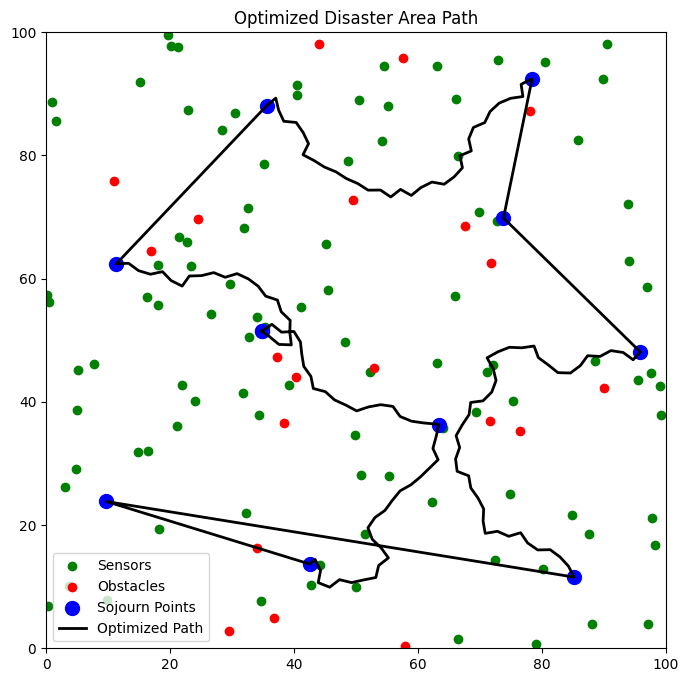

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans

# Environment parameters
AREA_SIZE = (100, 100)
NUM_SENSORS = 100
NUM_OBSTACLES = 20
NUM_SP = 10  # Number of sojourn points
COVERAGE_RADIUS = 20

# Initialize environment (sensors and obstacles)
sensors = np.random.rand(NUM_SENSORS, 2) * AREA_SIZE
obstacles = np.random.rand(NUM_OBSTACLES, 2) * AREA_SIZE

def plot_environment(sensors, obstacles, path=None, SPs=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(sensors[:, 0], sensors[:, 1], c='green', label='Sensors')
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='red', label='Obstacles')
    if SPs is not None:
        plt.scatter(SPs[:, 0], SPs[:, 1], c='blue', label='Sojourn Points', s=100)
    if path is not None:
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'k-', linewidth=2, label='Optimized Path')
    plt.xlim(0, AREA_SIZE[0])
    plt.ylim(0, AREA_SIZE[1])
    plt.legend()
    plt.title('Optimized Disaster Area Path')
    plt.show()

def fitness_func(SPs, sensors):
    distances = np.linalg.norm(SPs[:, np.newaxis] - sensors, axis=2)
    covered = np.sum(np.any(distances <= COVERAGE_RADIUS, axis=0))
    SP_distances = np.linalg.norm(SPs[:, np.newaxis] - SPs, axis=2)
    overlap_penalty = -np.sum((SP_distances < COVERAGE_RADIUS) & (SP_distances > 0)) / len(SPs)
    return covered + overlap_penalty

def optimize_SPs(sensors):
    kmeans = KMeans(n_clusters=NUM_SP, random_state=0).fit(sensors)
    return kmeans.cluster_centers_

def tsp_solver(SPs):
    num_SP = len(SPs)
    G = nx.complete_graph(num_SP)
    for i in range(num_SP):
        for j in range(i + 1, num_SP):
            distance = np.linalg.norm(SPs[i] - SPs[j])
            G[i][j]['weight'] = distance
            G[j][i]['weight'] = distance
    best_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    return np.array([SPs[i] for i in best_path])

def rrt_star_path(start, goal, obstacles, max_iter=500, step_size=2):
    nodes = [start]
    parents = {tuple(start): None}
    obstacle_tree = cKDTree(obstacles)
    for _ in range(max_iter):
        rnd_point = np.random.rand(2) * AREA_SIZE
        node_tree = KDTree(nodes)
        _, nearest_idx = node_tree.query(rnd_point)
        nearest_node = nodes[nearest_idx]
        direction = rnd_point - nearest_node
        direction /= np.linalg.norm(direction)
        new_node = tuple(nearest_node + step_size * direction)
        if obstacle_tree.query(new_node, k=1)[0] < 2:
            continue
        nodes.append(new_node)
        parents[new_node] = nearest_node
        if np.linalg.norm(np.array(new_node) - goal) <= step_size:
            nodes.append(tuple(goal))
            parents[tuple(goal)] = new_node
            break
    path = []
    current = tuple(goal)
    while current is not None:
        path.append(current)
        current = parents.get(tuple(current))
    return path[::-1]
def calculate_total_distance(path):
    """Calculate total Euclidean distance of the path."""
    total_distance = sum(np.linalg.norm(np.array(path[i]) - np.array(path[i + 1])) for i in range(len(path) - 1))
    return total_distance
def IMO_HPP():
    OptimizedSPs = optimize_SPs(sensors)
    scheduled_SPs = tsp_solver(OptimizedSPs)
    final_path = []

    for i in range(len(scheduled_SPs) - 1):
        segment = rrt_star_path(scheduled_SPs[i], scheduled_SPs[i + 1], obstacles)
        final_path.extend(segment)  # Ensuring all points are included
    
    # Ensure the path returns to the start
    final_path.extend(rrt_star_path(scheduled_SPs[-1], scheduled_SPs[0], obstacles))

    plot_environment(sensors, obstacles, final_path, scheduled_SPs)

IMO_HPP()

In [ ]:
Final Ant colony optimised approach giving the shortest route